This tutorial is based on the work of Chris Wang (who was in high school at the time), my colleague Paul Kienzle, and myself (William Ratcliff)

The first thing we will do is to add some modules to our environment.  We will also update tensorflow to the latest version

In [2]:
!pip install pybind11 appdirs decorator
#!pip install opencl # somehow opencl doesn't seem to work
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 4.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Please make sure that you have created an "APS2025_Tutorial" Folder in your Google Drive


In [4]:
%cd "/content/gdrive/My Drive/APS2025_Tutorial/"
!ls


/content/gdrive/My Drive/APS2025_Tutorial
sasmodels  sasnets


The code for this tutorial lives on github.   You will only want to run this line when you are in the correct directory.

In [5]:
%cd "/content/gdrive/My Drive/APS2025_Tutorial/"
!git clone https://github.com/scattering/sasnets.git
!git clone https://github.com/pkienzle/sasmodels

/content/gdrive/My Drive/APS2025_Tutorial
fatal: destination path 'sasnets' already exists and is not an empty directory.
fatal: destination path 'sasmodels' already exists and is not an empty directory.


In [6]:
%cd "/content/gdrive/My Drive/APS2025_Tutorial/sasnets"
!ls

/content/gdrive/My Drive/APS2025_Tutorial/sasnets
bin   LICENSE	 rasmixed.db  run_range.sh  savenet   smallnet.db
docs  model.png  README.md    sasnets	    setup.py  tensorboard


Now we will generate some sample SANS curves for samples that are either cylinders or spheres

In [7]:
#Generate cylinders and spheres
!ls
!python bin/sasgen --count 2000  --database=smallnet.db cylinder sphere

bin   LICENSE	 rasmixed.db  run_range.sh  savenet   smallnet.db
docs  model.png  README.md    sasnets	    setup.py  tensorboard
Selected models:
   
Total computation time (s): 0.11
Total memory usage: 106056.00


The data was stored in a database (local).  Let's plot it up.  What do you notice?


tables: [('train',)]


True

4000

{'cylinder', 'sphere'}

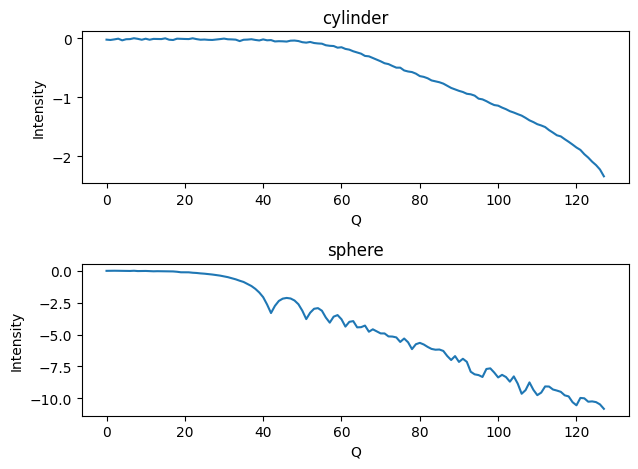

In [8]:
#Let's see what the data looks like
from sasnets.sas_io import sql_connect, sql_tables, read_sql

conn=sql_connect(dbfile=r'smallnet.db')
t_tables=sql_tables(conn)
display(t_tables)
iq, label = read_sql(conn, 'train')
display(len(iq))
display(set(label))

import matplotlib.pyplot as plt

fig=plt.figure()
ax1=plt.subplot(2, 1, 1)
plt.plot(iq[0])
plt.title(label[0])
plt.ylabel('Intensity')
plt.xlabel('Q')

ax1=plt.subplot(2, 1, 2)
plt.plot(iq[3000])
plt.title(label[3000])
plt.ylabel('Intensity')
plt.xlabel('Q')

plt.tight_layout()


The next set of code blocks will be useful for setting up our neural network

In [9]:
# System imports
import argparse
import logging
import os
import sys
import time
import random
import json

# Installed packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Embedding, \
    MaxPooling1D, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# SASNets packages
from sasnets import sas_io
from sasnets.util.utils import inepath


In [10]:
# Define the argparser parameters
parser = argparse.ArgumentParser(
    description="Use neural nets to classify scattering data.")
parser.add_argument(
    "--train", type=str, default="train",
    help="Training data table.")
parser.add_argument(
    "--validation", type=str, default="30",
    help="Validation data table, or percent of training data.")
parser.add_argument(
    "--test", type=str, default="10",
    help="Test data table, or percent of training data.")
parser.add_argument(
    "--database", type=str, default=sas_io.DB_FILE,
    help="Path to the sqlite database file.")
parser.add_argument(
    "--steps", type=int, default=None,
    help="Number of steps per epochs.")
parser.add_argument(
    "--epochs", type=int, default=50,
    help="Number of epochs.")
parser.add_argument(
    "--batch", type=int, default=5,
    help="Batch size.")
parser.add_argument(
    "--tensorboard", type=str, default="tensorboard",
    help="Tensorboard directory.")
parser.add_argument(
    "-v", "--verbose", action="store_true",
    help="Control output verbosity")
parser.add_argument(
    "-r", "--resume", action='store_true', dest='resume',
    help="resume fit stored in --save-path")
parser.add_argument(
    "--noresume", action='store_false', dest='resume',
    help="don't resume fit stored in --save-path")
parser.set_defaults(feature=True)
parser.add_argument(
    "-s", "--save-path", default="./savenet/out",
    help="Path to save model weights and info to")


_StoreAction(option_strings=['-s', '--save-path'], dest='save_path', nargs=None, const=None, default='./savenet/out', type=None, choices=None, required=False, help='Path to save model weights and info to', metavar=None)

In [11]:
class OnehotEncoder:
    def __init__(self, categories):
        self.categories = sorted(categories)
        self.label_encoder = LabelEncoder().fit(self.categories)
        self.hotlen = len(categories)

    def __call__(self, y):
        return to_categorical(self.label_encoder.transform(y), self.hotlen)

    def index(self, y):
        return self.label_encoder.transform(y)

    def label(self, index):
        return self.label_encoder.inverse_transform(index)


In [12]:
def reload_net(path):
    """
    Loads a classifier saved by sasnets from *path*.

    :param path: Relative or absolute path to the .h5 model file
    :return: The loaded classifier.
    """
    return keras.models.load_model(os.path.normpath(path))

def save_output(save_path, model, encoder, history, seed, score):
    # Create output directory.
    basename = inepath(save_path)
    if basename is not None:
        model.save(basename + ".h5")
        out = {
            'categories': encoder.categories,
            'history': history.history,
            # seed is used to split training and evaluation data.
            # for sqlite it does nothing.
            'seed': seed,
            'score': score,
        }
        with open(basename + ".history.json", 'w') as fd:
            json.dump(out, fd, cls=sas_io.NpEncoder)
        plot_history(history, basename=basename)

def plot_history(history, basename=None):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    with open(basename + ".svg", 'w') as fd:
        plt.savefig(fd, format='svg', bbox_inches='tight')

def read_data(opts):
    time_start = time.perf_counter()
    #q, iq, label, n = sas_io.read_1d_seq(opts.path, tag=opts.train, verbose=verbose)
    db = sas_io.sql_connect(opts.database)
    iq, label = sas_io.read_sql(db, opts.train)
    db.close()
    time_end = time.perf_counter()
    logging.info(f"File I/O Took {time_end-time_start} seconds for {len(label)} points of data.")
    return np.asarray(iq), label


In [13]:
def sql_net(opts):
    """
    A 1D convnet that uses a generator reading from a SQL database
    instead of loading all files into memory at once.
    """
    verbose = 1 if opts.verbose else 0
    db = sas_io.sql_connect(opts.database)
    counts = model_counts(db, tag=opts.train)
    encoder = OnehotEncoder(counts.keys())
    train_seq = sas_io.iread_sql(
        db, opts.train, encoder=encoder, batch_size=opts.batch)
    validation_seq = sas_io.iread_sql(
        db, opts.validation, encoder=encoder, batch_size=opts.batch)

    # Grab some training data so we can see how big it is
    x, y = next(train_seq)

    tb = TensorBoard(log_dir=opts.tensorboard, histogram_freq=1)
    es = EarlyStopping(min_delta=0.001, patience=15, verbose=verbose)

    # Begin model definitions
    nq = len(x[0])
    model = Sequential()
    model.add(Conv1D(nq, kernel_size=8, activation='relu', input_shape=[nq, 1]))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(.17676))
    model.add(Conv1D(nq//2, kernel_size=6, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(.20782))
    model.add(Flatten())
    model.add(Dense(nq//4, activation='tanh'))
    model.add(Dropout(.20582))
    model.add(Dense(nq//4, activation='softmax'))
    model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    # Model Run
    if verbose > 0:
        print(model.summary())
    history = model.fit_generator(
        train_seq, steps_per_epoch=opts.steps, epochs=opts.epochs,
        workers=1, verbose=verbose, validation_data=validation_seq,
        max_queue_size=1, callbacks=[tb, es])

    score = None
    if xval is not None and yval is not None:
        score = model.evaluate(xval, yval, verbose=verbose)
        print('\nTest loss: ', score[0])
        print('Test accuracy:', score[1])

    save_output(
        save_path=opts.save_path,
        model=model,
        encoder=encoder,
        history=history,
        seed=None,
        score=score)
    logging.info("Complete.")

In [14]:
def trad_nn(x, y, xtest=None, ytest=None, seed=235):
    """
    Runs a traditional MLP categorisation neural net on the input data x and y.

    :param x: List of training data x.
    :param y: List of corresponding categories for each vector in x.
    :param seed: Random seed. Defaults to 235 for reproducibility purposes, but should be set randomly in an actual run.
    :param xevl: Evaluation data for model.
    :param yevl: Evaluation data for model.
    :return: None
    """
    verbose = 1

    categories = sorted(set(y))
    encoder = OnehotEncoder(categories)
    xtrain, xval, ytrain, yval= train_test_split(
        x, encoder(y), test_size=.25, random_state=seed)
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=x.shape[1]))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(set(y)), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam",
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(xtrain, ytrain, batch_size=10, epochs=10,
                        verbose=verbose, validation_data=(xval, yval))
    if xtest and ytest:
        score = model.evaluate(xtest, ytest, verbose=verbose)
        print('Test loss: ', score[0])
        print('Test accuracy:', score[1])

    #plot_history(history, basename=basename)




In [15]:
def fix_dims(*args):
    """
    Insert extra dimension on inputs for image channel.

    Keras seems to require an extra dimension on the inputs, which is
    either at the start or the end of the input item, depending on the
    backend in use.  Usual is at the end?
    """
    order = keras.backend.image_data_format()
    if order == 'channels_last':
        fixer = lambda x: np.asarray(x)[..., None]
    elif order == 'channels_first':
        fixer = lambda x: np.asarray(x)[:, None, ...]
    else:
        raise ValueError(f"unknown image data format {order}")
    if len(args) == 0:
        return fixer
    if len(args) == 1:
        return fixer(args[0])
    return (fixer(v) for v in args)


This is the actual example that we will work with

In [16]:
def oned_convnet(opts, x, y, test=None, seed=235):
    """
    Runs a 1D convolutional classification neural net on the input data x and y.

    :param x: List of training data x.
    :param y: List of corresponding categories for each vector in x.
    :param xtest: List of evaluation data.
    :param ytest: List of corresponding categories for each vector in x.
    :param seed: Random seed. Defaults to 235 for reproducibility purposes, but should be set randomly in an actual run.
    :param verbose: Either true or false. Controls level of output.
    :param save_path: The path to save the model to. If it points to a directory, writes to a file named the current unix time. If it points to a file, the file is overwritten.
    :return: None.
    """
    verbose = 1 if opts.verbose else 0

    # 1-hot encoding.
    categories = sorted(set(y))
    encoder = OnehotEncoder(categories)

    # Split data into train and validation.
    test_size = float(opts.validation)/100
    xtrain, xval, ytrain, yval = train_test_split(
        x, encoder(y), test_size=test_size, random_state=seed)

    # We need to poke an extra dimension into our input data for some reason.
    if 1:
      xtrain, xval = fix_dims(xtrain, xval) #change for embedding or not embedding?
    nq, nlabels = x.shape[1], len(categories)

    # Check that the validation data covers all the categories
    #if categories != sorted(set(ytrain)):
    #    raise ValueError("Training data is missing categories.")
    #if categories != sorted(set(yval)):
    #    raise ValueError("Test data is missing categories.")

    tb = TensorBoard(log_dir=opts.tensorboard, histogram_freq=1)
    #es = EarlyStopping(min_delta=0.005, patience=5, verbose=verbose)
    basename = inepath(opts.save_path)
    checkpoint = ModelCheckpoint(
        filepath=basename+"-check.h5", # or "-check{epoch:03d}.h5",
        ## To keep best loss, and not overwrite every epoch.
        #monitor='loss', save_best_only=True, mode='auto',
        )

    if opts.resume:
        model = reload_net(inepath(opts.save_path)+'.h5')
        print("model resume shape", model.layers[0].input_shape[1:] )
    else:
        # Begin model definitions
        model = Sequential()
        #model.add(Embedding(4000, 128, input_length=x.shape[1]))
        if 0:
          print('nq')
          print(nq)
          print('shape')
          print(x.shape)
          model.add(Embedding(2000, x.shape[0], input_length=nq))
          model.add(Conv1D(2000, kernel_size=6, activation='relu'))
        if 1:
          model.add(InputLayer(input_shape=(nq,1)))
          model.add(Conv1D(nq, kernel_size=6, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(.17676))
        model.add(Conv1D(nq//2, kernel_size=6, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(.20782))
        model.add(Flatten())
        model.add(Dense(nq//4, activation='tanh'))
        model.add(Dropout(.20582))
        model.add(Dense(nlabels, activation='softmax'))
        loss = ('binary_crossentropy' if nlabels == 2
                else 'categorical_crossentropy')
        model.compile(loss=loss, optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])
    if verbose > 0:
        print(model.summary())

    # Model Run
    history = model.fit(
        xtrain, ytrain, batch_size=opts.batch,
        steps_per_epoch=opts.steps, epochs=opts.epochs,
        verbose=verbose, validation_data=(xval, yval),
        #callbacks=[tb, es, checkpoint],
        callbacks=[tb, checkpoint],
        )

    # Check the results against the validation data.
    score = None
    if test is not None:
        if categories != sorted(set(test[1])):
            raise ValueError("Validation data has missing categories.")
        score = model.evaluate(test[0], encoder(test[1]), verbose=verbose)
        print('\nTest loss: ', score[0])
        print('Test accuracy:', score[1])

    save_output(
        save_path=opts.save_path,
        model=model,
        encoder=encoder,
        history=history,
        seed=seed,
        score=score)
    logging.info("Complete.")

In [17]:
def main(args):
    """
    Main method. Takes in arguments from command line and runs a model.

    :param args: Command line args.
    :return: None.
    """
    opts = parser.parse_args(args)
    data, label = read_data(opts)
    #print(data.shape)
    seed = random.randint(0, 2 ** 32 - 1)
    logging.info(f"Random seed for this iter is {seed}")
    oned_convnet(opts, data, label, seed=seed)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 123, 128)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 25, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,498 (244.13 KB)

 Trainable params: 62,498 (244.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
544/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4913 - loss: 0.7395

560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4911 - loss: 0.7394 - val_accuracy: 0.3658 - val_loss: 0.7030
Epoch 2/50
550/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4742 - loss: 0.7250

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4744 - loss: 0.7249 - val_accuracy: 0.4083 - val_loss: 0.6971
Epoch 3/50
552/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4783 - loss: 0.7202

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4785 - loss: 0.7201 - val_accuracy: 0.4592 - val_loss: 0.6948
Epoch 4/50
545/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4920 - loss: 0.7102

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4923 - loss: 0.7102 - val_accuracy: 0.4558 - val_loss: 0.6940
Epoch 5/50
546/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4997 - loss: 0.7152

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4994 - loss: 0.7152 - val_accuracy: 0.4625 - val_loss: 0.6937
Epoch 6/50
546/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4893 - loss: 0.7094

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4895 - loss: 0.7094 - val_accuracy: 0.4700 - val_loss: 0.6935
Epoch 7/50
544/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5111 - loss: 0.7029

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5106 - loss: 0.7030 - val_accuracy: 0.4775 - val_loss: 0.6933
Epoch 8/50
558/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5093 - loss: 0.7046

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5093 - loss: 0.7046 - val_accuracy: 0.4733 - val_loss: 0.6930
Epoch 9/50
554/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5070 - loss: 0.7075

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5069 - loss: 0.7075 - val_accuracy: 0.4650 - val_loss: 0.6927
Epoch 10/50
549/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4987 - loss: 0.7082

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4987 - loss: 0.7081 - val_accuracy: 0.4675 - val_loss: 0.6923
Epoch 11/50
553/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5087 - loss: 0.7045

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5086 - loss: 0.7046 - val_accuracy: 0.4875 - val_loss: 0.6920
Epoch 12/50
548/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4981 - loss: 0.7035

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4981 - loss: 0.7036 - val_accuracy: 0.4967 - val_loss: 0.6916
Epoch 13/50
547/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4931 - loss: 0.7088

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4932 - loss: 0.7088 - val_accuracy: 0.5100 - val_loss: 0.6914
Epoch 14/50
556/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 0.7004

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5218 - loss: 0.7004 - val_accuracy: 0.5133 - val_loss: 0.6909
Epoch 15/50
544/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5087 - loss: 0.7024

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5084 - loss: 0.7025 - val_accuracy: 0.5183 - val_loss: 0.6907
Epoch 16/50
551/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5357 - loss: 0.6953

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5353 - loss: 0.6954 - val_accuracy: 0.5317 - val_loss: 0.6903
Epoch 17/50
558/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5173 - loss: 0.7025

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5173 - loss: 0.7025 - val_accuracy: 0.5383 - val_loss: 0.6899
Epoch 18/50
550/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4893 - loss: 0.7052

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4894 - loss: 0.7052 - val_accuracy: 0.5392 - val_loss: 0.6896
Epoch 19/50
555/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5064 - loss: 0.7029

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5064 - loss: 0.7029 - val_accuracy: 0.5433 - val_loss: 0.6895
Epoch 20/50
546/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5200 - loss: 0.6994

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5198 - loss: 0.6994 - val_accuracy: 0.5542 - val_loss: 0.6892
Epoch 21/50
545/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4908 - loss: 0.7023

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4914 - loss: 0.7022 - val_accuracy: 0.5625 - val_loss: 0.6889
Epoch 22/50
549/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5009 - loss: 0.6991

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5010 - loss: 0.6991 - val_accuracy: 0.5725 - val_loss: 0.6888
Epoch 23/50
544/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5063 - loss: 0.6982

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5065 - loss: 0.6982 - val_accuracy: 0.5817 - val_loss: 0.6884
Epoch 24/50
555/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5145 - loss: 0.7006

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5145 - loss: 0.7006 - val_accuracy: 0.5900 - val_loss: 0.6882
Epoch 25/50
549/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4817 - loss: 0.7049

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4822 - loss: 0.7048 - val_accuracy: 0.5967 - val_loss: 0.6879
Epoch 26/50
547/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5287 - loss: 0.6959

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5286 - loss: 0.6959 - val_accuracy: 0.6008 - val_loss: 0.6876
Epoch 27/50
544/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5453 - loss: 0.6951

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5451 - loss: 0.6952 - val_accuracy: 0.6058 - val_loss: 0.6875
Epoch 28/50
545/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4825 - loss: 0.7053

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4836 - loss: 0.7051 - val_accuracy: 0.6117 - val_loss: 0.6873
Epoch 29/50
556/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5402 - loss: 0.6952

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5403 - loss: 0.6951 - val_accuracy: 0.6167 - val_loss: 0.6868
Epoch 30/50
557/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5286 - loss: 0.6987

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5287 - loss: 0.6987 - val_accuracy: 0.6158 - val_loss: 0.6865
Epoch 31/50
554/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5381 - loss: 0.6930

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5382 - loss: 0.6929 - val_accuracy: 0.6217 - val_loss: 0.6862
Epoch 32/50
543/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5382 - loss: 0.6941

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5382 - loss: 0.6940 - val_accuracy: 0.6242 - val_loss: 0.6858
Epoch 33/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5251 - loss: 0.6964

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5252 - loss: 0.6963 - val_accuracy: 0.6275 - val_loss: 0.6856
Epoch 34/50
548/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5241 - loss: 0.6963

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5243 - loss: 0.6963 - val_accuracy: 0.6300 - val_loss: 0.6855
Epoch 35/50
543/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5268 - loss: 0.6942

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5268 - loss: 0.6943 - val_accuracy: 0.6308 - val_loss: 0.6855
Epoch 36/50
543/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5501 - loss: 0.6912

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5496 - loss: 0.6913 - val_accuracy: 0.6375 - val_loss: 0.6852
Epoch 37/50
550/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5604 - loss: 0.6947

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5605 - loss: 0.6947 - val_accuracy: 0.6383 - val_loss: 0.6849
Epoch 38/50
548/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5483 - loss: 0.6909

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5480 - loss: 0.6910 - val_accuracy: 0.6308 - val_loss: 0.6846
Epoch 39/50
556/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5506 - loss: 0.6884

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5507 - loss: 0.6884 - val_accuracy: 0.6350 - val_loss: 0.6841
Epoch 40/50
551/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5652 - loss: 0.6857

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5649 - loss: 0.6857 - val_accuracy: 0.6583 - val_loss: 0.6840
Epoch 41/50
550/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5778 - loss: 0.6838

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5777 - loss: 0.6838 - val_accuracy: 0.6600 - val_loss: 0.6837
Epoch 42/50
559/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5354 - loss: 0.6932

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5355 - loss: 0.6932 - val_accuracy: 0.6650 - val_loss: 0.6835
Epoch 43/50
555/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5572 - loss: 0.6884

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5570 - loss: 0.6884 - val_accuracy: 0.6675 - val_loss: 0.6832
Epoch 44/50
544/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5542 - loss: 0.6878

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5540 - loss: 0.6878 - val_accuracy: 0.6700 - val_loss: 0.6830
Epoch 45/50
555/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5936 - loss: 0.6824

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5935 - loss: 0.6824 - val_accuracy: 0.6725 - val_loss: 0.6826
Epoch 46/50
550/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5697 - loss: 0.6873

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5697 - loss: 0.6872 - val_accuracy: 0.6750 - val_loss: 0.6823
Epoch 47/50
556/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5659 - loss: 0.6837

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5658 - loss: 0.6837 - val_accuracy: 0.6808 - val_loss: 0.6820
Epoch 48/50
545/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5512 - loss: 0.6865

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5514 - loss: 0.6865 - val_accuracy: 0.6758 - val_loss: 0.6816
Epoch 49/50
554/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5511 - loss: 0.6861

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5512 - loss: 0.6861 - val_accuracy: 0.6808 - val_loss: 0.6812
Epoch 50/50
548/560 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5639 - loss: 0.6882

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5640 - loss: 0.6881 - val_accuracy: 0.6842 - val_loss: 0.6810


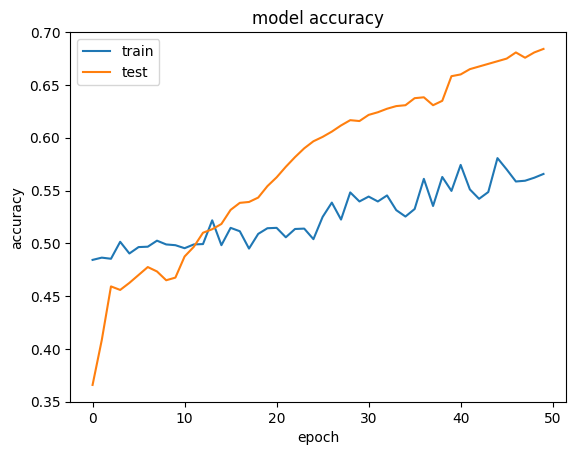

In [18]:
main(['-v','--epochs=50', '--database=smallnet.db'])
#main(['-v','--epochs=50', '--database=rasmixed.db', '-r'])

In [22]:
!pwd
!ls
!python bin/sasanal --database smallnet.db  -c savenet/out.h5
#!python bin/sasanal --database rasmixed.db savenet/out.h5

/content/gdrive/MyDrive/APS2025_Tutorial/sasnets
bin   LICENSE	 rasmixed.db  run_range.sh  savenet   smallnet.db  testdb.db
docs  model.png  README.md    sasnets	    setup.py  tensorboard
2025-03-15 14:45:34.064714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742049934.086865   12330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742049934.093675   12330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 14:45:37.566720: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1742049937.566903   1

In [20]:
%cd ../sasnets/
!ls
!python bin/sasgen cylinder --database testdb.db

/content/gdrive/My Drive/APS2025_Tutorial/sasnets
bin   LICENSE	 rasmixed.db  run_range.sh  savenet   smallnet.db
docs  model.png  README.md    sasnets	    setup.py  tensorboard
Selected models:
   
INFO:root:cc -std=c99 -O2 -Wall -fPIC -shared /tmp/sas64_cylinder_BC70FC69_0wrl3myr.c -o /root/.sasmodels/compiled_models/sas64_cylinder_BC70FC69.so -lm
generating cylinder 1 of 1000
Complete cylinder
Total computation time (s): 0.65
Total memory usage: 1503288.00


In [21]:
%cd "/content/gdrive/My Drive/APS2025_Tutorial/"
%cd sasnets
!ls
!git pull

/content/gdrive/My Drive/APS2025_Tutorial
/content/gdrive/My Drive/APS2025_Tutorial/sasnets
bin   LICENSE	 rasmixed.db  run_range.sh  savenet   smallnet.db  testdb.db
docs  model.png  README.md    sasnets	    setup.py  tensorboard
Already up to date.
